<a href="https://colab.research.google.com/github/DavidPachis/DeepLearning/blob/main/taller2/Taller2DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

Fabián Ramirez, David Vásquez

{fo.ramirez50, da.vasquez11} @uniandes.edu.co

Fecha de presentación: Septiembre 20 del 2022


# **Taller 2**

Uno de los campos de aplicación de las técnicas de deep learning es la medicina, donde se han desarrollado sistemas que ayudan a los expertos en el diagnóstico y que facilitan la detección temprana de algunas patologías. Este es el caso de algunas enfermedades del ojo, las cuales pueden ser identificadas mediante un análisis automatizado de imágenes de la retina del paciente. De esta forma, se puede apoyar la toma de decisiones oportunas para prevenir la ceguera y otras complicaciones.


En este sentido, se quiere llevar a cabo un estudio, tomando como base imágenes de retina de retinopatía diabética, de cataratas y de glaucoma, para construir un modelo que apoye en la identificación de pacientes con riesgo de sufrir estas enfermedades.

Para la construcción del modelo, es importante que realicen su propia Red Neuronal para la clasificación de estas enfermedades. En donde es importante explorar tanto sus propias redes, como Redes Pre-entrenadas. Realice una tabla comparativa entre la Red Construida y por lo menos dos Redes Pre-entrenadas con la métrica seleccionada.

Datos: https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images

## Instalaciones e Importaciones

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 29.1 MB/s 
     |████████████████████████████████| 1.6 MB 42.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


## 1. Perfilamiento y entendimiento de los datos

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gunavenkatdoddi/preprocessed-eye-diseases-fundus-images


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 97% 457M/472M [00:06<00:00, 103MB/s]
100% 472M/472M [00:06<00:00, 76.8MB/s]


In [ ]:
! unzip preprocessed-eye-diseases-fundus-images.zip

Archive:  preprocessed-eye-diseases-fundus-images.zip
  inflating: seg_dataset/cataract/0_left.jpg  
  inflating: seg_dataset/cataract/103_left.jpg  
  inflating: seg_dataset/cataract/1062_right.jpg  
  inflating: seg_dataset/cataract/1083_left.jpg  
  inflating: seg_dataset/cataract/1084_right.jpg  
  inflating: seg_dataset/cataract/1102_left.jpg  
  inflating: seg_dataset/cataract/1102_right.jpg  
  inflating: seg_dataset/cataract/1115_left.jpg  
  inflating: seg_dataset/cataract/1126_right.jpg  
  inflating: seg_dataset/cataract/112_right.jpg  
  inflating: seg_dataset/cataract/1144_left.jpg  
  inflating: seg_dataset/cataract/1144_right.jpg  
  inflating: seg_dataset/cataract/1164_left.jpg  
  inflating: seg_dataset/cataract/1167_right.jpg  
  inflating: seg_dataset/cataract/119_left.jpg  
  inflating: seg_dataset/cataract/1285_left.jpg  
  inflating: seg_dataset/cataract/1415_left.jpg  
  inflating: seg_dataset/cataract/1415_right.jpg  
  inflating: seg_dataset/cataract/1435_left.

## 2. Preparación de datos

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


Clases cargadas en los datos

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Muestra de las imágenes redimensionadas

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


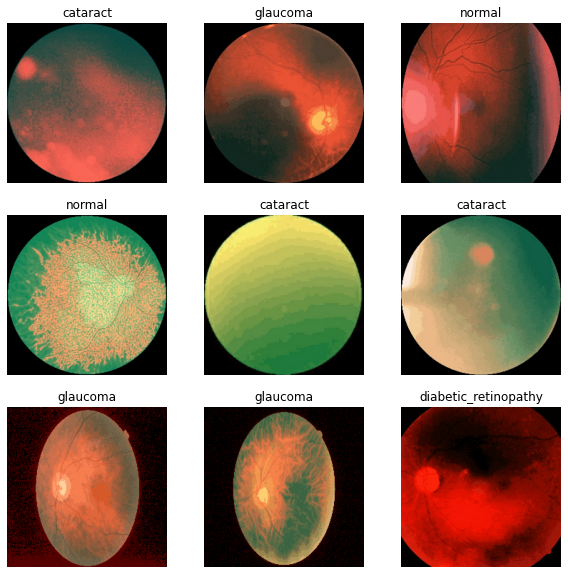

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

## Modelamiento con INCEPTIONV3


Hacemos la primera prueba con el modelo inception v3, así como en el ejemplo del monitor, debido a que tambien nos enfrentamos a un problema de clasificacion de imagenes. 

In [ ]:
base_model = InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

In [ ]:
clf = Sequential(name='eye_disease')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(50, activation="relu", name='Dense_1'))
clf.add(Dense(10, activation="relu", name='Dense_2'))
clf.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf.summary()

Model: "eye_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 4)                 44        
                                                                 
Total params: 21,905,788
Trainable params: 21,871,356
Non-trainable params: 34,432
______________________________________

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

In [ ]:
with tf.device('/device:GPU:0'): 
    history = clf.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 1505s 14s/step - loss: 0.4673 - acc: 0.8320 - precision: 0.8608 - recall: 0.7993 - val_loss: 1.6924 - val_acc: 0.6679 - val_precision: 0.6892 - val_recall: 0.6524
Epoch 2/50
106/106 [==============================] - 1499s 14s/step - loss: 0.3587 - acc: 0.8654 - precision: 0.8832 - recall: 0.8539 - val_loss: 0.6094 - val_acc: 0.8244 - val_precision: 0.8307 - val_recall: 0.8149
Epoch 3/50
106/106 [==============================] - 1501s 14s/step - loss: 0.3333 - acc: 0.8767 - precision: 0.8872 - recall: 0.8651 - val_loss: 0.4783 - val_acc: 0.8066 - val_precision: 0.8181 - val_recall: 0.7948
Epoch 4/50
106/106 [==============================] - 1503s 14s/step - loss: 0.2279 - acc: 0.9182 - precision: 0.9244 - recall: 0.9129 - val_loss: 0.4522 - val_acc: 0.8529 - val_precision: 0.8580 - val_recall: 0.8458
Epoch 5/50
106/106 [==============================] - 1503s 14s/step - loss: 0.1878 - acc: 0.9327 - precision: 0.9374 - recall: 0.92

Debido a nuestro CallBack, tenemos que de las 50 epochs que programamamos, en la 8 se dejo de evidenciar un cambio significatio en el Val_recall.

Definimos esta como metrica de callback, debido a la naturaleza dle problema. Esto devido a que el recall es lo mas importante a discriminar en caso de clasificacion, pues se desea minimizar la cantidad de casos que etiquetean como sanos, pero realemnte estan enfermos. 

### Predicción 

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32), array([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]))

Utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.88      0.83      0.85       836
diabetic_retinopathy       1.00      0.71      0.83       884
            glaucoma       0.93      0.58      0.72       802
              normal       0.58      0.99      0.73       852

           micro avg       0.78      0.78      0.78      3374
           macro avg       0.85      0.78      0.78      3374
        weighted avg       0.85      0.78      0.79      3374
         samples avg       0.78      0.78      0.78      3374



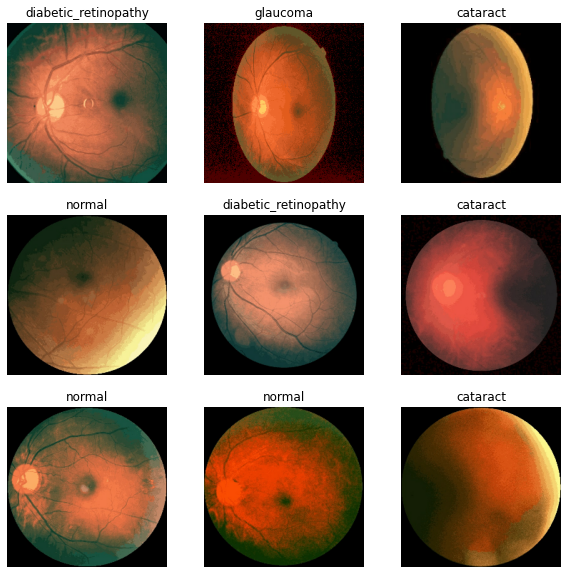

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.
Alli podemos ver como la perdida de test auemnta al final, pero en rangos de .1, con respecto a la de entrenamiento. 

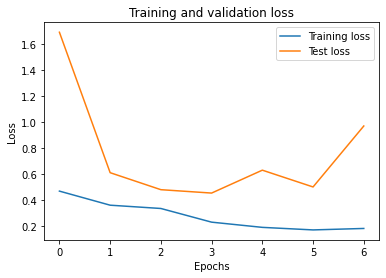

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

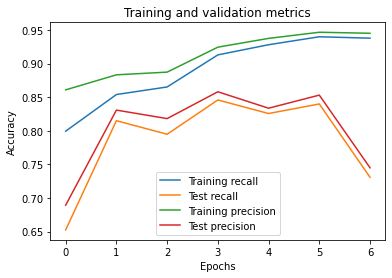

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5. Validación

Mismos pasos, pero esta vez con nuestros datos de validación.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32), array([[0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        ...,
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]]))

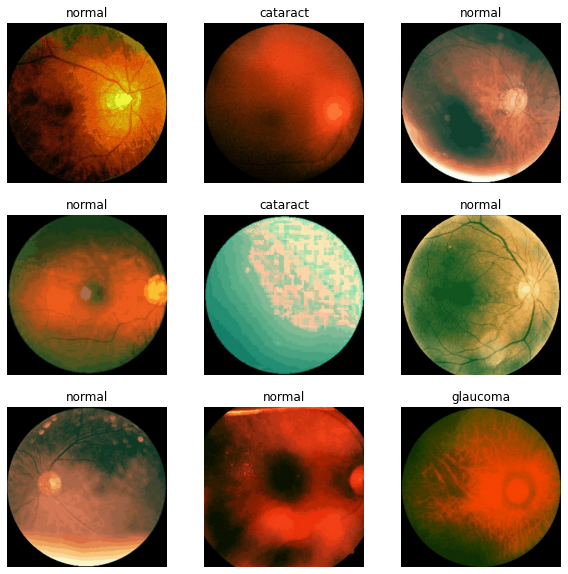

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

## Modelamiento con RESNET50

Utilizaremos una Red preentrenada como lo es la [RESNET(https://keras.io/api/applications/resnet/#resnet50-function). La cuál está optimizada para mobile y nos ayudará a la tarea de procesamiento de imágenes.

![image](https://miro.medium.com/max/1400/0*tH9evuOFqk8F41FG.png)

In [ ]:
base_model1 = ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
clf_rest = Sequential(name='eye_disease')

clf_rest.add(base_model1)
clf_rest.add(GlobalAveragePooling2D(name='Pooling'))
clf_rest.add(Dense(50, activation="relu", name='Dense_1'))
clf_rest.add(Dense(10, activation="relu", name='Dense_2'))
clf_rest.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf_rest.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf_rest.summary()

Model: "eye_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 4)                 44        
                                                                 
Total params: 23,690,716
Trainable params: 23,637,596
Non-trainable params: 53,120
______________________________________

Usamos el mismo callback definido en el entrenamiento anterior

In [ ]:
with tf.device('/device:GPU:0'): 
    history = clf_rest.fit(train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks = my_callbacks
    )

Epoch 1/10
106/106 [==============================] - 2868s 27s/step - loss: 0.6802 - acc: 0.7312 - precision: 0.8007 - recall: 0.6538 - val_loss: 9.3374 - val_acc: 0.3630 - val_precision: 0.3627 - val_recall: 0.3618
Epoch 2/10
106/106 [==============================] - 2708s 26s/step - loss: 0.4262 - acc: 0.8361 - precision: 0.8593 - recall: 0.8088 - val_loss: 1.6582 - val_acc: 0.6429 - val_precision: 0.6641 - val_recall: 0.6192
Epoch 3/10
106/106 [==============================] - 2722s 26s/step - loss: 0.3492 - acc: 0.8634 - precision: 0.8830 - recall: 0.8477 - val_loss: 1.1451 - val_acc: 0.6856 - val_precision: 0.6970 - val_recall: 0.6441
Epoch 4/10
106/106 [==============================] - 2774s 26s/step - loss: 0.3179 - acc: 0.8705 - precision: 0.8839 - recall: 0.8530 - val_loss: 0.3228 - val_acc: 0.8814 - val_precision: 0.9015 - val_recall: 0.8683
Epoch 5/10
106/106 [==============================] - 2822s 27s/step - loss: 0.2855 - acc: 0.8862 - precision: 0.8953 - recall: 0.87

### Predicción 

In [ ]:
y_true_rest = list()
y_pred_rest = list()

for images, labels in train_ds:
    pred = clf_rest.predict(images)
    for i in range(len(pred)):
        y_true_rest.append(labels[i].numpy())
        y_pred_rest.append((pred[i] == pred[i].max()).astype(int))

y_true_rest = np.array(y_true_rest)
y_pred_rest = np.array(y_pred_rest)
y_true_rest, y_pred_rest

1/1 [==============================] - 4s 4s/step


(array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32), array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]))

Resumen del desempeño del modelo, plasmado en la matriz de confusión, en comparacion a nuestro primer modelo, con el inceotion, tenemos que se evidencia un mejor dedempeño en la  clasidicacion de normal para las muestras. 
En la siguiente celda podemos ver la clasificación visual de las muestras. 

In [ ]:
print(classification_report(y_true_rest,y_pred_rest,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.73      0.94      0.82       836
diabetic_retinopathy       1.00      0.90      0.95       884
            glaucoma       0.81      0.62      0.70       802
              normal       0.77      0.80      0.79       852

           micro avg       0.82      0.82      0.82      3374
           macro avg       0.83      0.82      0.82      3374
        weighted avg       0.83      0.82      0.82      3374
         samples avg       0.82      0.82      0.82      3374



1/1 [==============================] - 5s 5s/step


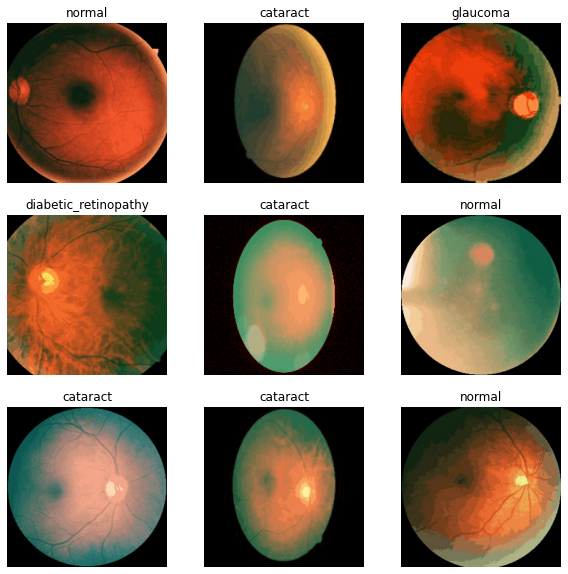

In [ ]:
plt.figure(figsize=(10, 10))

df_rest = train_ds.take(1)

for images, labels in df_rest:
    pred = clf_rest.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Debido a la complejidad de, dominio, no podemos definir vizualmente si la clasificacion está realizando un buen trabajo ni que nivel de diferencia visual tiene una clasificacion de la otra. Por ello se graficó la matriz de confusión dónde tenemos los estadisticos que nos definen el comportamiento real del modleo basado en etiquetas. 

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

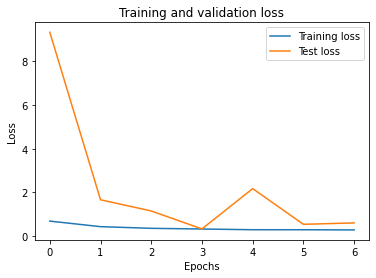

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

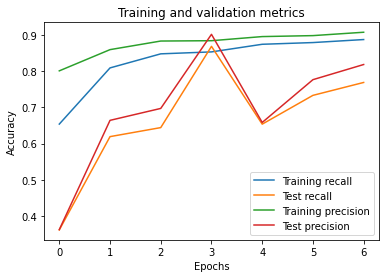

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Luego de la revisar el comportameinto de las graficas, agendamos como trabajo futuro, modificar el callback, para comprovbar que si el modelo podria estabilizarce. Otor camino tambien puede ser modificar el modelo de clasificacion que agregamos en la nuestro modelo final. 

### Validación

#### Predicción

In [ ]:
y_true_rest = list()
y_pred_rest = list()

for images, labels in val_ds:
    pred = clf_rest.predict(images)
    for i in range(len(pred)):
        y_true_rest.append(labels[i].numpy())
        y_pred_rest.append((pred[i] == pred[i].max()).astype(int))

y_true_rest = np.array(y_true_rest)
y_pred_rest = np.array(y_pred_rest)
y_true_rest, y_pred_rest

1/1 [==============================] - 6s 6s/step


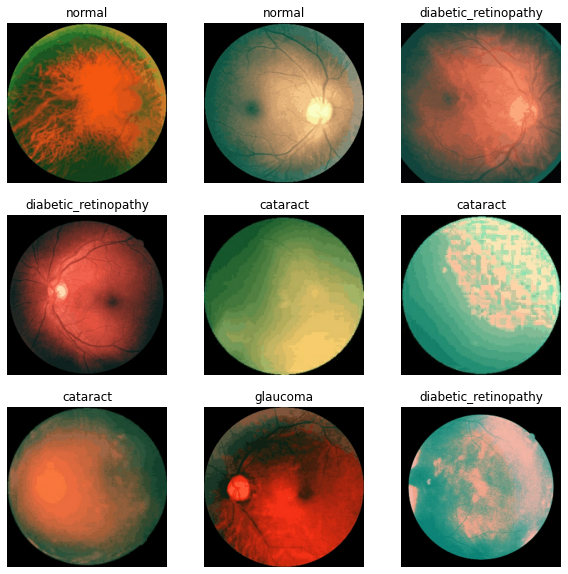

In [ ]:
plt.figure(figsize=(10, 10))

df_rest = val_ds.take(1)

for images, labels in df_rest:
    pred = clf_rest.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Cómo, se evidencio en Inception, la categoria mas perjudicada en el la clasificación es "NORMAL", pues luego de ver varios ejemplos, esta es la que se clasifica con menor desempeño a lo largo de los dos modelos. 

## Comparación


Inception vs. Resnet50 

![image](https://raw.githubusercontent.com/DavidPachis/DeepLearning/main/taller2/SumaryMix.png)

Luego de hacer una comparación de los resultados de cada modelo, podemos evidenciar que la resnet, tuvo un lijero mejor desempeño ante la inception.
La presición tiene una mejor distribucion en Resnet, aunque esta diferencia aplicada a problema dependera del experto. Por lo cual, saber si el nivel de confiabilidad de los dos modelos es suficiente, se debe comprobar con el experto y es estado del arte de detección de este tipo de clasificación médica. 

La resnet, como se evidencia en los modelos, tiene una mayor cantidad de paramwtros a entrenar y no entrenables. Debido a que entrar al detalle de las dos arquitecturas, se torna complejo, concluiremos que el cambio Y el incremento de paramtros de la resnet sumado a su arquitectura, arrojo un desempeño de clasificación más distribuido en las imagenes. Esto debido a que los otros hiperparametros se mantuvieron iguales en dos modelamientos. 

**Conclusiones del para el negocio**:
A pesar de no tener concimiento específico del dominio del problema, se evidecia que hay categorias que presentan un gran solapamiento, por lo cuál, a pensar de tener un desempeño superior al 80 %, se debe profundizar más en el entrenameinto, en la parte de la red de clasificación a la que se le transfiere el conocimeinto de las redes pre-entrendas. En adición a este, el acompañamiento del experto, puede ayudar a entender el porque del solapamiento de las categorias de las imágenes desde el ambito médico. Para así poder encontar un punto de equilibrio dónde la red aprenda a diferenciar mejor dichas clasificaciones. 